# official tutorial

In [15]:
from torch.optim import Adam

from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.models import TransEModel
from torchkge.utils.datasets import load_fb15k
from torchkge.utils import Trainer, MarginLoss


def main():
    # Define some hyper-parameters for training
    emb_dim = 100
    lr = 0.0004
    margin = 0.5
    n_epochs = 1000
    batch_size = 32768

    # Load dataset
    kg_train, kg_val, kg_test = load_fb15k()
    ''' load_fb15k (data preparation)
    returns 
    - kg_train (torchkge.data_structures.KnowledgeGraph)
    - kg_val (torchkge.data_structures.KnowledgeGraph)
    - kg_test (torchkge.data_structures.KnowledgeGraph)
    '''
    # Define the model and criterion
    model = TransEModel(emb_dim,
                        kg_train.n_ent, 
                        kg_train.n_rel,
                        dissimilarity_type='L2')
    ''' TransE model
    - emb_dim(int) - Dimension of the embedding.
    - n_entities(int) - Number of entities in the current data set.
    - n_relations(int) - Number of relations in the current data set.
    - disimilairty _type (str) - Either 'L1' or 'L2'    
    
    -- dismilarity 
    -- l1 ; Compute dissimiliarity between rows of a and b as ||a-b||_{1}.
    
    '''
    
    criterion = MarginLoss(margin)
    
    ''' MarginLoss
    - positive_triplets (torch.Tensor) - Scores of the true tiplets as retruned by the forward methods of the models.
    - negative_triplets (torch.Tensor) - Scores of the negative triplets as returned by the forward methods of the models.
    
    RETURN
    
    - loss (torch.Tensor) ; loss of the form max(0, \gamma - f(h,r,t) + f(h', r', t'))
    -- where \gamma is the margin (defined at initializiation)
    -- f(h,r,t) is the score of a true fact
    -- f(h',r',t') is the score of the associated negative fact
    
    '''
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    trainer = Trainer(model,
                      criterion,
                      kg_train,
                      n_epochs,
                      batch_size,
                      optimizer=optimizer,
                      sampling_type='bern', # important
                      use_cuda='all',)
    ''' Trainer Wrapper
    - model (torchkge.models.interfaces.Model) - Model to be trained.
    - criterion - Criteria which should differentiate positive and negative scores.
    --> Can be an elements of torchkge.utils.losses
    - 
    
    sampling_type
    - uniform ; either the head or the tail of a tiplet is replaced by another entity at random. choice is uniform.
    - Bernoull ; using probabilities taking into account profiles of the relations.
    - postional ; replaced by another entity chose among entities that have already appeared at the same place in a triplet
    '''
    
    trainer.run()

    evaluator = LinkPredictionEvaluator(model, kg_test)
    ''' LinkPredictionEvaluator Wrapper
    Evaluate performance of given embedding using link prediction method.
    
    evaluation metrics ; 'hit_at_k','mean_rank','mrr'    
    '''
    evaluator.evaluate(200)
    evaluator.print_results()


if __name__ == "__main__":
    main()

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Link prediction evaluation:   0%|          | 0/296 [00:00<?, ?batch/s]

Hit@10 : 0.507 		 Filt. Hit@10 : 0.684
Mean Rank : 216 	 Filt. Mean Rank : 119
MRR : 0.253 		 Filt. MRR : 0.423


# application tutorial (recsys)

In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import cuda
from torch.optim import Adam
from tqdm import tqdm


from torchkge.models import TransEModel , TransRModel, ComplExModel, DistMultModel
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils import MarginLoss, BinaryCrossEntropyLoss , DataLoader
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.data_structures import KnowledgeGraph
from torchkge.inference import RelationInference

import torch, gc
gc.collect()
torch.cuda.empty_cache()

# data preparation

In [3]:
import pyarrow
from pyarrow import csv

In [94]:
for curDir, dirs, files in os.walk('DATA'):
    for f in files:
        if f in 'train.tsv':
            print(os.path.join(curDir, f))
            #csv.read_csv('')

DATA/s1/train.tsv
DATA/s2/train.tsv
DATA/s3/train.tsv
DATA/t1/train.tsv
DATA/t2/train.tsv


In [4]:
s1_tb = csv.read_csv('DATA/s1/train.tsv')
s2_tb = csv.read_csv('DATA/s2/train.tsv')
s3_tb = csv.read_csv('DATA/s3/train.tsv')
t1_tb = csv.read_csv('DATA/t1/train.tsv')
t2_tb = csv.read_csv('DATA/t2/train.tsv')

In [5]:
print(len(t1_tb))
print(len(pyarrow.concat_tables([t1_tb,s1_tb])))
print(len(pyarrow.concat_tables([t1_tb,s1_tb,s2_tb])))

print(f'concat all dataset description; {len(pyarrow.concat_tables([t1_tb,t2_tb,s1_tb,s2_tb,s3_tb]))}')
df = pyarrow.concat_tables([t1_tb,t2_tb,s1_tb,s2_tb,s3_tb]).to_pandas()['userId\titemId\trating'].str.split('\t', expand=True).rename(columns={0:'userId',\
                                                                                                                     1:'itemId',\
                                                                                                                    2:'rating'})

60168
900380
1015929
concat all dataset description; 1190451


In [6]:
df.head(5)

,userId,itemId,rating
0,t1U1006129,P1016853,5.0
1,t1U1002135,P1019605,5.0
2,t1U1006710,P1032538,5.0
3,t1U1007418,P1012632,5.0
4,t1U1008062,P1022775,5.0


In [7]:
# usermap = {user : i for i , user in enumerate(df['userId'])}
# ratingmap = {rate : i for i , rate in enumerate(df['rating'])}
# itemmap = {item : i for i , item in enumerate(df['itemId'])}

# # inv_map = {v : k for k , v in map.items()}

# inv_usermap = {i : user for i , user in enumerate(df['userId'])}
# inv_ratingmap = {i : rate for i , rate in enumerate(df['rating'])}
# inv_itemmap = {i : item for i , item in enumerate(df['itemId'])}
# entity_ori = np.concatenate([df['userId'].values ,df['itemId'].values])
# entitymap = {entity : i for i , entity in enumerate(entity_ori)}

# df2['rel'].map(lambda x : ratingmap.get(x))
# df2['from'].map(lambda x : entitymap.get(x))
# df2['to'].map(lambda x : entitymap.get(x))

print(f'originally counts {len(df)}\n\nuser nunique {len(usermap)}, item nunique {len(itemmap)}\n\n')
print(inv_usermap.get(0),'\n\n')
print(df2['rel'].value_counts())

NameError: name 'usermap' is not defined

In [9]:
df2 = df.copy()
df2.columns = ['from','to','rel']
df2.head(1)

,from,to,rel
0,t1U1006129,P1016853,5.0


In [10]:
kg = KnowledgeGraph(df2)
kg_train, kg_val, kg_test = kg.split_kg(share = 0.8,
                                        validation=True)

# embedding

## version 1

only training

In [72]:
emb_params = {'ent_emb_dim' : 100,
              'rel_emb_dim' : 100,
             'lr' : 0.0004,
             'n_epochs' : 100,
             'b_size' : 32768,
             'margin' : 0.5}

In [188]:
# Define the model and criterion
model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
criterion = MarginLoss(margin)

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda='all')

iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

Epoch 1000 | mean loss: 20.66059: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:29<00:00,  1.96epoch/s]


## version 2

with test(inference)

In [15]:
def main():
    # Define some hyper-parameters for training
    emb_dim = 1000
    lr = 0.0004
    margin = 0.5
    n_epochs = 100
    batch_size = 32768

    # Load dataset
    kg_train, kg_val, kg_test = kg.split_kg(share = 0.8,
                                        validation=True)

    # Define the model and criterion
    model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel,
                        dissimilarity_type='L2')
    criterion = MarginLoss(margin)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    trainer = Trainer(model, criterion, kg_train, n_epochs, batch_size,
                      optimizer=optimizer, sampling_type='bern', use_cuda='all',)

    trainer.run()

    evaluator = LinkPredictionEvaluator(model, kg_test)
    evaluator.evaluate(200)
    evaluator.print_results()


if __name__ == "__main__":
    main()

KeyboardInterrupt: 

# model comparsion

### Translation Models

#### transE

In [12]:
# Define the model and criterion
model_transE = TransEModel(emb_params.get('emb_dim'),
                    kg_train.n_ent,
                    kg_train.n_rel,
                    dissimilarity_type='L2')
criterion = MarginLoss(emb_params.get('margin'))

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model_transE.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model_transE.parameters(), lr=emb_params.get('lr'), weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=emb_params.get('b_size'), use_cuda='all')

iterator = tqdm(range(emb_params.get('n_epochs')), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model_transE(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model_transE.normalize_parameters()

Epoch 100 | mean loss: 773.00311: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10epoch/s]


In [13]:
model_transE

TransEModel(
  (ent_emb): Embedding(231691, 100)
  (rel_emb): Embedding(5, 100)
)

In [14]:
emb_entity_ = model_transE.get_embeddings()[0].detach().cpu().numpy()

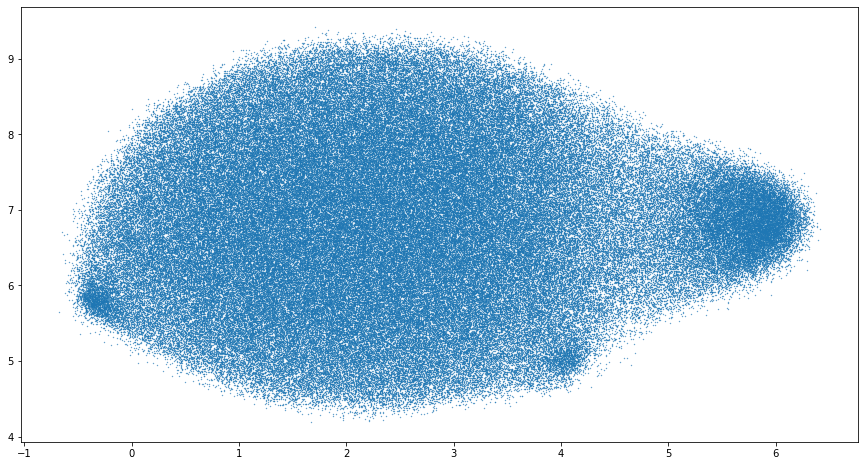

In [48]:
%%time
umap_emb = umap.UMAP(random_state=42).fit_transform(emb_entity_)
plt.figure(figsize=(15,8))
plt.scatter(umap_emb[:,0], umap_emb[:,1], s=0.1, cmap='Sectral')

#### transR

In [75]:
%%time
# Define the model and criterion
model_transR = TransRModel(ent_emb_dim = emb_params.get('ent_emb_dim'),
                          rel_emb_dim = emb_params.get('rel_emb_dim'),
                          n_entities = kg_train.n_ent,
                          n_relations = kg_train.n_rel,)
                    #dissimilarity_type='L2')
criterion = MarginLoss(emb_params.get('margin'))


# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model_transR.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model_transR.parameters(), lr=emb_params.get('lr'), weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=emb_params.get('b_size'), use_cuda='all')

iterator = tqdm(range(emb_params.get('n_epochs')), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model_transR(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model_transR.normalize_parameters()

Epoch 100 | mean loss: 1580.86688: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:20<00:00,  2.61s/epoch]


CPU times: user 11min 11s, sys: 2min 44s, total: 13min 55s
Wall time: 5min 8s


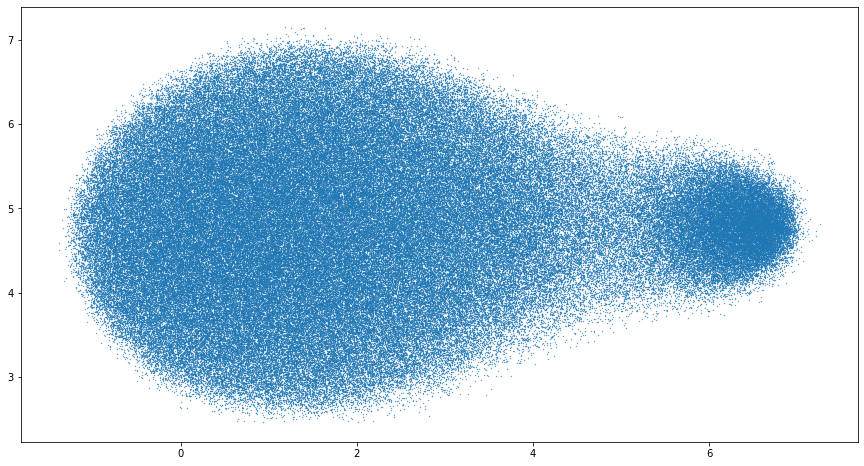

In [76]:
%%time
emb_entity_transR = model_transR.get_embeddings()[0].detach().cpu().numpy()
umap_emb = umap.UMAP(random_state=42).fit_transform(emb_entity_transR)
plt.figure(figsize=(15,8))
plt.scatter(umap_emb[:,0], umap_emb[:,1], s=0.1, cmap='Sectral')

### Bilinear Models

#### DistMult

In [100]:
# Define the model and criterion
# model_distMult = DistMultModel(emb_dim = emb_params.get('emb_dim'),
#                     n_entities = kg_train.n_ent,
#                     n_relations = kg_train.n_rel,
#                     )
model_distMult = DistMultModel(emb_dim = 100,
             n_entities = 231691,
             n_relations = 5)

criterion = MarginLoss(emb_params.get('margin'))

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model_distMult.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model_distMult.parameters(), lr=emb_params.get('lr'), weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=emb_params.get('b_size'), use_cuda='all')

iterator = tqdm(range(emb_params.get('n_epochs')), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model_distMult(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model_distMult.normalize_parameters()

Epoch 100 | mean loss: 361.92733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09epoch/s]


CPU times: user 13min, sys: 3min 52s, total: 16min 52s
Wall time: 5min 48s


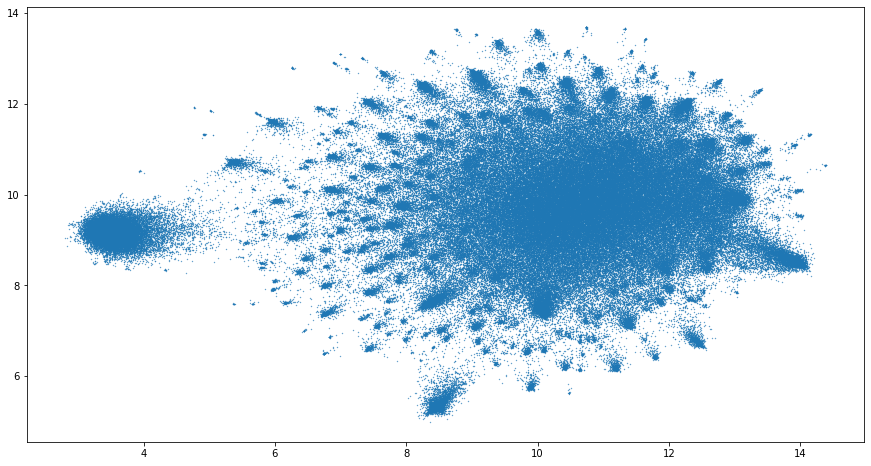

In [107]:
%%time
emb_entity_distMult = model_distMult.get_embeddings()[0].detach().cpu().numpy()
umap_emb = umap.UMAP(random_state=42).fit_transform(emb_entity_distMult)
plt.figure(figsize=(15,8))
plt.scatter(umap_emb[:,0], umap_emb[:,1], s=0.1, cmap='Sectral')

#### ComplEx

In [104]:
# Define the model and criterion
model_complEx = ComplExModel(emb_dim = 100,
             n_entities = 231691,
             n_relations = 5)

criterion = MarginLoss(emb_params.get('margin'))

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model_complEx.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model_complEx.parameters(), lr=emb_params.get('lr'), weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=emb_params.get('b_size'), use_cuda='all')

iterator = tqdm(range(emb_params.get('n_epochs')), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model_complEx(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model_complEx.normalize_parameters()

Epoch 100 | mean loss: 11.26624: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22epoch/s]


CPU times: user 12min 55s, sys: 3min 22s, total: 16min 17s
Wall time: 6min 3s


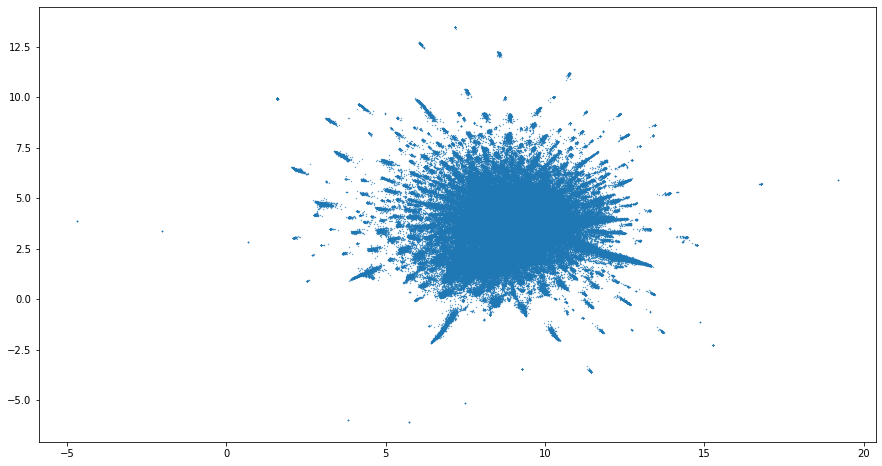

In [106]:
%%time
emb_entity_complEx = model_complEx.get_embeddings()[0].detach().cpu().numpy()
umap_emb = umap.UMAP(random_state=42).fit_transform(emb_entity_complEx)
plt.figure(figsize=(15,8))
plt.scatter(umap_emb[:,0], umap_emb[:,1], s=0.1, cmap='Sectral')

# code written by jeong , ii tae (graphlover)

if u have a question in this tutorial , then give me the email.

address is jeongiitae6@gmail.com